In [0]:
import csv
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, ThresholdedReLU, Flatten, Lambda, Concatenate
from keras.models import Sequential
from tensorflow.keras import Model
import tensorflow_hub as hub
import collections
import matplotlib.pyplot as plt
from sklearn import metrics
# tf.test.gpu_device_name() 

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# downloaded = drive.CreateFile({'id':'1LAXYuJapp6u6shheA3ciIy67GrOQdlKs'}) 
# downloaded.GetContentFile('q2_revised.csv')  

In [0]:
df = pd.read_csv('/content/drive/Shared drives/Hackathon_new/q2_revised.csv', encoding='latin1')
# Dataset is now stored in a Pandas Dataframe
gt = pd.read_excel('/content/drive/Shared drives/Hackathon_new/q2_answer.xlsx')

In [0]:
df.head() #Time.1 is time between query and response. Ignore text item, didn't mean to include that. reply code says if there is an error. Primary server name shows the the nameserver after SOA in the query

# Part 1: classify the malicious DNS and benign DNS

### prepare the data
input is the DNS string
output is 1 or 0. 1 means malicious and 0 means benign

In [0]:
data_x = df.Name.unique()
len(data_x)

61298

In [0]:
# check all the ground truth dns are in the train_x
x_set = set(data_x)
for dns in gt.domain:
    if dns not in x_set:
        print(dns)

In [0]:
# there are some 42 dns are both in family 1 and 2. I guess
# they are in 2 since they end with '.ws'. 
gt_set = set()
repeat_dns = []
for dns in gt.domain:
    if dns not in gt_set:
        gt_set.add(dns)
    else:
        repeat_dns.append(dns)
# repeat_dns

In [0]:
dic = collections.defaultdict(int)
for row in gt[(gt.family == 2)].iterrows():
  dic[row[1].domain.split('.')[-1]] += 1
print(dic)

defaultdict(<class 'int'>, {'ws': 237})


In [0]:
dic = collections.defaultdict(int)
for row in gt[(gt.family == 1)].iterrows():
  dic[row[1].domain.split('.')[-1]] += 1
print(dic)

defaultdict(<class 'int'>, {'so': 41, 'in': 42, 'tk': 40, 'ws': 42, 'to': 42})


In [0]:
# drop domain name with TLD '.ws' in family 1 
drop_idx = [] #drop index
for dns in repeat_dns:
    drop_idx.append(gt[(gt.domain==dns) & (gt.family == 1)].index[0])

ngt = gt.drop(drop_idx) #new answers

In [0]:
gt_set = set(ngt.domain)
data_y = []
for dns in data_x:
    if dns in gt_set:
        data_y.append(1)
    else:
        data_y.append(0)


In [0]:
p1_data = pd.DataFrame(list(zip(data_x, data_y)), columns =['dns', 'isDGA'])
p1_data = p1_data.sample(frac=1, random_state=202005)
# p1_data['dnsLength'] = p1_data.dns.apply(lambda x: len(x))

In [0]:
p1_data[p1_data.dns.isna()]

,dns,isDGA
157,NaN,0


In [0]:
p1_data.drop([157],inplace=True)

In [0]:
def dnsToMatrix(dns):
    maxl = 63
    asc = [ord(i.lower()) for i in dns]
    if len(asc) > 63: # if domain name is longer than 63, just use the last 63
        asc = asc[-63:]
    else:
        asc = [0] * (maxl-len(asc)) + asc
    asc = np.array(asc)
    
    return asc

In [0]:
np_x = []
for dns in p1_data.dns:
    np_x.append(dnsToMatrix(dns))
np_x = np.stack(np_x, axis=0)

In [0]:
# split data into train (80%), validation (10%) and test (10%)
n = len(p1_data)
train_ratio = 0.8 
val_ratio = 0.1
test_ratio = 0.1

train_x = np_x[:int(n*train_ratio),:]
train_y = p1_data.isDGA[:int(n*train_ratio)]

val_x = np_x[int(n*train_ratio):int(n*(train_ratio+val_ratio)),:]
val_y = p1_data.isDGA[int(n*train_ratio):int(n*(train_ratio+val_ratio))]

test_x = np_x[int(n*(train_ratio+val_ratio)):,:]
test_y = p1_data.isDGA[int(n*(train_ratio+val_ratio)):]

In [0]:
print('DGA ratio in train:', sum(train_y) / len(train_y))
print('DGA ratio in val:', sum(val_y) / len(val_y))
print('DGA ratio in test:', sum(test_y) / len(test_y))

DGA ratio in train: 0.18021086118645105
DGA ratio in val: 0.1869494290375204
DGA ratio in test: 0.17455138662316477


# Baseline Model with only Embedding Layer

In [0]:
main_input = Input(shape=(63,), dtype='int32', name='input')
embedding = Embedding(input_dim=128, output_dim=200, input_length=63)(main_input)
flatten = Flatten()(embedding)
output = Dense(1, activation='sigmoid')(flatten)
Bmodel = Model(inputs=main_input, outputs=output)
Bmodel.summary()
Bmodel.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 63)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 63, 200)           25600     
_________________________________________________________________
flatten (Flatten)            (None, 12600)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 12601     
Total params: 38,201
Trainable params: 38,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = Bmodel.fit(train_x, train_y,
                    batch_size=64,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    class_weight={0:1, 1:1})

Epoch 1/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1860 - val_loss: 0.1796
Epoch 2/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1489 - val_loss: 0.1501
Epoch 3/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1438 - val_loss: 0.1477
Epoch 4/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1404 - val_loss: 0.1467
Epoch 5/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1386 - val_loss: 0.1437
Epoch 6/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1381 - val_loss: 0.1396
Epoch 7/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1364 - val_loss: 0.1448
Epoch 8/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1369 - val_loss: 0.1466
Epoch 9/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1364 - val_loss: 0.1436
Epoch 10/10
767/767 [==============================] - 3s 4ms/step - loss: 0.1350 - val_loss: 0.1435

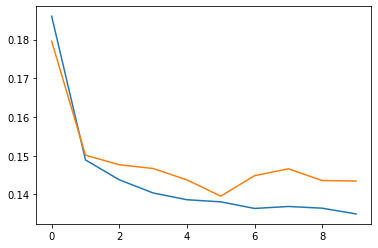

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

2821
0.57270175


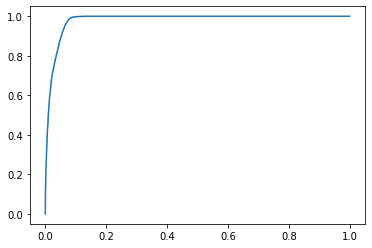

In [0]:
train_y_predict = Bmodel.predict(train_x)
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_predict, pos_label=1)
# Receiver operating characteristic (ROC) curve
plt.plot(fpr,tpr)

# choose the threshold whose false positive rate is about 0.05 for training data
for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break

print(thresholds[i])
thres = thresholds[i]

In [0]:
# socre of part 1
def getSocre1(test_y_predict, test_y, thres):
    score_1 = 0
    test_y = np.array(test_y)
    N = sum(test_y)
    for i in range(len(test_y)):
        if test_y_predict[i] >= thres:
            predict = 1
        else:
            predict = 0
        if predict == 1 and test_y[i] == 1:
            score_1 += 1
        elif predict == 1 and test_y[i] == 0:
            score_1 -= 1
    return max(score_1/N, 0)

# True positive, true negative, false positive, false negative 
def Calrate(predict, truth, thres):
    tp = tn = fp = fn = 0
    predict = np.array(predict)
    truth = np.array(truth)
    for i in range(len(predict)):
        if predict[i] >= thres:
            pre = 1
        else:
            pre = 0 
        if truth[i] == 1:
            if pre == 1:
              tp += 1
            else:
              fn += 1
        else:
            if pre == 1:
              fp += 1
            else:
              tn += 1
    return (tp, tn, fp, fn)

In [0]:
val_y_predict = Bmodel.predict(val_x)
test_y_predict = Bmodel.predict(test_x)

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))


train score: 0.6583, val score: 0.6449, test score: 0.5953
train precision: 0.7956, val precision: 0.7921, test precision: 0.7706
train recall: 0.8858, val recall: 0.8743, test recall: 0.8477


## Modified MIT Model

In [0]:
# S. Vosoughi, P. Vijayaraghavan, and D. Roy, “Tweet2vec: Learning tweet
# embeddings using character-level cnn-lstm encoder-decoder,” in Proceedings 
# of the 39th International ACM SIGIR conference on Research
# and Development in Information Retrieval, 2016, pp. 1041–1044.

main_input = Input(shape=(63,), dtype='int32', name='input')
embedding = Embedding(input_dim=128, output_dim=200, input_length=63)(main_input)
conv = Conv1D(filters=200, kernel_size=3, padding='same', activation='relu', strides=1)(embedding)
max_pool = MaxPooling1D(pool_size=2, padding='same')(conv)
encode = Bidirectional(LSTM(64, return_sequences=False))(max_pool)
# encode = Bidirectional(LSTM(64, return_sequences=False))(encode)
output = Dense(1, activation='sigmoid')(encode)

model = Model(inputs=main_input, outputs=output)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 63)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 63, 200)           25600     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 63, 200)           120200    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 32, 200)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               135680    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 281,609
Trainable params: 281,609
Non-trainable params: 0
_____________________________________________________

In [0]:
history = model.fit(train_x, train_y,
                    batch_size=64,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    class_weight={0:1, 1:1})

Epoch 1/10
767/767 [==============================] - 8s 10ms/step - loss: 0.1849 - val_loss: 0.1493
Epoch 2/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1378 - val_loss: 0.1274
Epoch 3/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1238 - val_loss: 0.1215
Epoch 4/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1195 - val_loss: 0.1232
Epoch 5/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1175 - val_loss: 0.1193
Epoch 6/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1161 - val_loss: 0.1189
Epoch 7/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1142 - val_loss: 0.1201
Epoch 8/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1141 - val_loss: 0.1226
Epoch 9/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1123 - val_loss: 0.1188
Epoch 10/10
767/767 [==============================] - 7s 10ms/step - loss: 0.1113 - val_lo

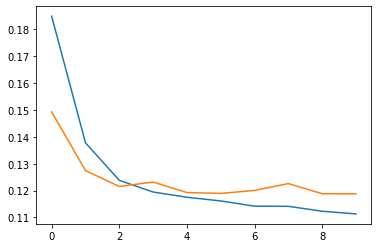

In [0]:
# check overfiiting. epoch = 10 is ok.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

2801
0.4575116


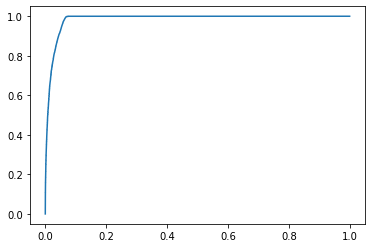

In [0]:
train_y_predict = model.predict(train_x)
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_predict, pos_label=1)
plt.plot(fpr,tpr)
for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break

print(thresholds[i])
thres = thresholds[i]

In [0]:
val_y_predict = model.predict(val_x)
test_y_predict = model.predict(test_x)

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

train score: 0.7000, val score: 0.7024, test score: 0.6738
train precision: 0.8030, val precision: 0.8094, test precision: 0.7845
train recall: 0.9276, val recall: 0.9188, test recall: 0.9290


**Score: about 8% improvement **

### add benign domain name filter 

In [0]:
# https://www.alexa.com/topsites
alexa = pd.read_csv('/content/drive/Shared drives/Hackathon_new/alexa.csv', header=None, names=['dns'], usecols=[1])
alexa = set(alexa.dns.unique())

In [0]:
for i, dns in enumerate(p1_data.dns[:int(n*train_ratio)]):
  if dns in alexa:
    train_y_predict[i] = 0

for i, dns in enumerate(p1_data.dns[int(n*train_ratio):int(n*(train_ratio+val_ratio))]):
  if dns in alexa:
    val_y_predict[i] = 0

for i, dns in enumerate(p1_data.dns[int(n*(train_ratio+val_ratio)):]):
  if dns in alexa:
    test_y_predict[i] = 0 

for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break
print(thresholds[i])
thres = thresholds[i]

2801
0.4575116


In [0]:
socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

train score: 0.7308, val score: 0.7216, test score: 0.7075
train precision: 0.8448, val precision: 0.8472, test precision: 0.8260
train recall: 0.8953, val recall: 0.8805, test recall: 0.8963


**Score: about 3% improvement **

In [0]:
# for stack model
mit_score = np.concatenate((train_y_predict, val_y_predict, test_y_predict), axis=0)

In [0]:
model.save('/content/drive/Shared drives/Hackathon_new/mit.model')
# mo = keras.models.load_model('/content/drive/Shared drives/Hackathon_new/mit.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/Shared drives/Hackathon_new/mit.model/assets


## End Game Model

In [0]:
# J. Woodbridge, H. S. Anderson, A. Ahuja, and D. Grant, “Predicting
# domain generation algorithms with long short-term memory networks,”
# preprint arXiv:1611.00791, 2016.

main_input = Input(shape=(63, ), dtype='int32', name='main_input')
embedding = Embedding(input_dim=128, output_dim=128, input_length=63)(main_input)
lstm = LSTM(128, return_sequences=False)(embedding)
drop = Dropout(0.5)(lstm)
output = Dense(1, activation='sigmoid')(drop)

EndgameModel = Model(inputs=main_input, outputs=output)
EndgameModel.summary()
EndgameModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 63)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 63, 128)           16384     
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 148,097
Trainable params: 148,097
Non-trainable params: 0
_________________________________________________________________


In [0]:
historyEndgame = EndgameModel.fit(train_x, train_y,
                    batch_size=64,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    class_weight={0:1, 1:1})

Epoch 1/10
767/767 [==============================] - 7s 9ms/step - loss: 0.2053 - accuracy: 0.8995 - val_loss: 0.1670 - val_accuracy: 0.9124
Epoch 2/10
767/767 [==============================] - 6s 8ms/step - loss: 0.1534 - accuracy: 0.9221 - val_loss: 0.1411 - val_accuracy: 0.9307
Epoch 3/10
767/767 [==============================] - 6s 8ms/step - loss: 0.1344 - accuracy: 0.9345 - val_loss: 0.1353 - val_accuracy: 0.9310
Epoch 4/10
767/767 [==============================] - 6s 8ms/step - loss: 0.1280 - accuracy: 0.9370 - val_loss: 0.1217 - val_accuracy: 0.9388
Epoch 5/10
767/767 [==============================] - 6s 8ms/step - loss: 0.1228 - accuracy: 0.9405 - val_loss: 0.1188 - val_accuracy: 0.9431
Epoch 6/10
767/767 [==============================] - 6s 8ms/step - loss: 0.1192 - accuracy: 0.9416 - val_loss: 0.1210 - val_accuracy: 0.9418
Epoch 7/10
767/767 [==============================] - 6s 8ms/step - loss: 0.1190 - accuracy: 0.9423 - val_loss: 0.1166 - val_accuracy: 0.9447
Epoch 

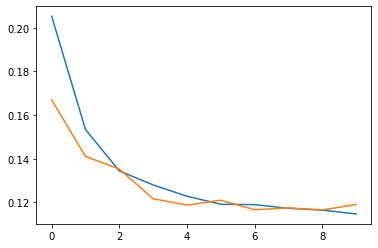

In [0]:
plt.plot(historyEndgame.history['loss'])
plt.plot(historyEndgame.history['val_loss'])

2845
0.5650618


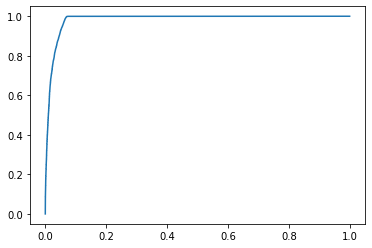

In [0]:
train_y_predict = EndgameModel.predict(train_x)
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_predict, pos_label=1)
plt.plot(fpr,tpr)
for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break

print(thresholds[i])
thres = thresholds[i]

In [0]:
val_y_predict = EndgameModel.predict(val_x)
test_y_predict = EndgameModel.predict(test_x)

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

train score: 0.6977, val score: 0.6972, test score: 0.6579
train precision: 0.8026, val precision: 0.8024, test precision: 0.7816
train recall: 0.9254, val recall: 0.9250, test recall: 0.9131


In [0]:
eg_score = np.concatenate((train_y_predict, val_y_predict, test_y_predict), axis=0)

## Invincea Model

In [0]:
# J. Saxe and K. Berlin, “eXpose: A character-level convolutional neural
# network with embeddings for detecting malicious urls, file paths and
# registry keys,” arXiv preprint arXiv:1702.08568, 2017.

main_input = Input(shape=(63, ), dtype='int32', name='main_input')
embedding = Embedding(input_dim=128, output_dim=128,input_length=75)(main_input)
conv1 = Conv1D(filters=256, input_shape=(128, 128), kernel_size=2, padding='same',activation='relu', strides=1)(embedding)
conv1 = Lambda(lambda x: keras.backend.sum(x, axis=1), output_shape=(256, ))(conv1)
conv1 = Dropout(0.5)(conv1)

conv2 = Conv1D(filters=256, input_shape=(128, 128), kernel_size=3, padding='same',activation='relu', strides=1)(embedding)
conv2 = Lambda(lambda x: keras.backend.sum(x, axis=1), output_shape=(256, ))(conv2)
conv2 = Dropout(0.5)(conv2)

conv3 = Conv1D(filters=256, input_shape=(128, 128), kernel_size=4, padding='same',activation='relu', strides=1)(embedding)
conv3 = Lambda(lambda x: keras.backend.sum(x, axis=1), output_shape=(256, ))(conv3)
conv3 = Dropout(0.5)(conv3)

conv4 = Conv1D(filters=256, input_shape=(128, 128), kernel_size=5, padding='same',activation='relu', strides=1)(embedding)
conv4 = Lambda(lambda x: keras.backend.sum(x, axis=1), output_shape=(256, ))(conv4)
conv4 = Dropout(0.5)(conv4)

merged = Concatenate()([conv1, conv2, conv3, conv4])
middle = Dense(1024, activation='relu')(merged)
middle = Dropout(0.5)(middle)
middle = Dense(1024, activation='relu')(middle)
middle = Dropout(0.5)(middle)
output = Dense(1, activation='sigmoid')(middle)

InvinceaModel = Model(inputs=main_input, outputs=output)
InvinceaModel.summary()
InvinceaModel.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 63)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 63, 128)      16384       main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 63, 256)      65792       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 63, 256)      98560       embedding_7[0][0]                
____________________________________________________________________________________________

In [0]:
historyInvincea = InvinceaModel.fit(train_x, train_y,
                    batch_size=64,
                    epochs=15,
                    validation_data=(val_x, val_y),
                    class_weight={0:1, 1:1})

Epoch 1/15
767/767 [==============================] - 7s 9ms/step - loss: 0.2185 - val_loss: 0.1607
Epoch 2/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1545 - val_loss: 0.1600
Epoch 3/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1465 - val_loss: 0.1427
Epoch 4/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1441 - val_loss: 0.1469
Epoch 5/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1417 - val_loss: 0.1394
Epoch 6/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1397 - val_loss: 0.1492
Epoch 7/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1391 - val_loss: 0.1396
Epoch 8/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1360 - val_loss: 0.1361
Epoch 9/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1357 - val_loss: 0.1328
Epoch 10/15
767/767 [==============================] - 7s 9ms/step - loss: 0.1329 - val_loss: 0.1346

2676
0.5576971


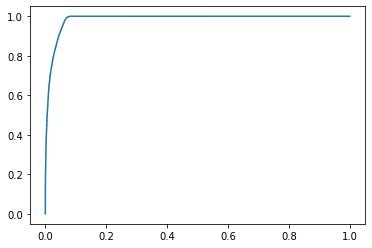

In [0]:
train_y_predict = InvinceaModel.predict(train_x)
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_predict, pos_label=1)
plt.plot(fpr,tpr)
for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break

print(thresholds[i])
thres = thresholds[i]

In [0]:
val_y_predict = InvinceaModel.predict(val_x)
test_y_predict = InvinceaModel.predict(test_x)

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

train score: 0.6950, val score: 0.6832, test score: 0.6421
train precision: 0.8020, val precision: 0.7991, test precision: 0.7768
train recall: 0.9229, val recall: 0.9127, test recall: 0.9009


In [0]:
in_score = np.concatenate((train_y_predict, val_y_predict, test_y_predict), axis=0)

## NYU Model

In [0]:
# X. Zhang, J. Zhao, and Y. LeCun, “Character-level convolutional
# networks for text classification,” in Advances in Neural Information
# Processing Systems, vol. 28, 2015, pp. 649–657.

main_input = Input(shape=(63, ), dtype='int32', name='main_input') 
embedding = Embedding(input_dim=128, output_dim=128, input_length=63)(main_input)
conv1 = Conv1D(filters=128, kernel_size=3, padding='same', strides=1)(embedding)
thresh1 = ThresholdedReLU(1e-6)(conv1)
max_pool1 = MaxPooling1D(pool_size=2, padding='same')(thresh1)
conv2 = Conv1D(filters=128, kernel_size=2, padding='same', strides=1)(max_pool1)
thresh2 = ThresholdedReLU(1e-6)(conv2)
max_pool2 = MaxPooling1D(pool_size=2, padding='same')(thresh2)
flatten = Flatten()(max_pool2)
fc = Dense(64)(flatten)
thresh_fc = ThresholdedReLU(1e-6)(fc)
drop = Dropout(0.5)(thresh_fc)
output = Dense(1, activation='sigmoid')(drop)

NyuModel = Model(inputs=main_input, outputs=output)
NyuModel.summary()
NyuModel.compile(loss='binary_crossentropy', optimizer='adam')

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 63)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 63, 128)           16384     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 63, 128)           49280     
_________________________________________________________________
thresholded_re_lu (Threshold (None, 63, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 128)           32896     
_________________________________________________________________
thresholded_re_lu_1 (Thresho (None, 32, 128)           0   

In [0]:
historyNyuModel = NyuModel.fit(train_x, train_y,
                    batch_size=64,
                    epochs=8,
                    validation_data=(val_x, val_y),
                    class_weight={0:1, 1:1})

Epoch 1/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1676 - val_loss: 0.1432
Epoch 2/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1371 - val_loss: 0.1259
Epoch 3/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1274 - val_loss: 0.1197
Epoch 4/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1224 - val_loss: 0.1215
Epoch 5/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1191 - val_loss: 0.1195
Epoch 6/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1148 - val_loss: 0.1205
Epoch 7/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1124 - val_loss: 0.1227
Epoch 8/8
767/767 [==============================] - 4s 5ms/step - loss: 0.1089 - val_loss: 0.1242


2497
0.47786847


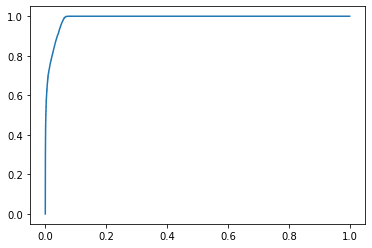

In [0]:
train_y_predict = NyuModel.predict(train_x)
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_predict, pos_label=1)
plt.plot(fpr,tpr)
for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break

print(thresholds[i])
thres = thresholds[i]

In [0]:
val_y_predict = NyuModel.predict(val_x)
test_y_predict = NyuModel.predict(test_x)

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

train score: 0.7214, val score: 0.6998, test score: 0.6738
train precision: 0.8066, val precision: 0.7997, test precision: 0.7788
train recall: 0.9490, val recall: 0.9337, test recall: 0.9411


In [0]:
for i, dns in enumerate(p1_data.dns[:int(n*train_ratio)]):
  if dns in alexa:
    train_y_predict[i] = 0

for i, dns in enumerate(p1_data.dns[int(n*train_ratio):int(n*(train_ratio+val_ratio))]):
  if dns in alexa:
    val_y_predict[i] = 0

for i, dns in enumerate(p1_data.dns[int(n*(train_ratio+val_ratio)):]):
  if dns in alexa:
    test_y_predict[i] = 0 

for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break
print(thresholds[i])
thres = thresholds[i]

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

2497
0.47786847
train score: 0.7536, val score: 0.7260, test score: 0.7140
train precision: 0.8502, val precision: 0.8421, test precision: 0.8237
train recall: 0.9148, val recall: 0.8935, test recall: 0.9084


**0.7140**

In [0]:
nyu_score = np.concatenate((train_y_predict, val_y_predict, test_y_predict), axis=0)

## Xgboost stack model


In [0]:
import sklearn
from sklearn import metrics
import time
import xgboost as xgb
from sklearn import preprocessing
from xgboost.sklearn import XGBClassifier as xgbc

In [0]:
stackModel= xgbc(silent=0,
        learning_rate=0.03,
        min_child_weight=1,
        max_depth=9,
        gamma=0.3,
        subsample=0.9,
        max_delta_step=0,
        colsample_bytree=0.8,
        colsample_bylevel=1,
        reg_alpha=0.01,
        reg_lambda=1,
        scale_pos_weight=1,
        n_estimators=200,
        objective='binary:logistic',
        seed=2020)

In [0]:
# DNSlength = np.array(p1_data.dnsLength) 
# DNSlength = DNSlength.reshape(len(DNSlength), 1)

In [0]:
data_x_stack = np.concatenate((mit_score, eg_score, in_score, nyu_score), axis=1)

In [0]:
train_x_stack = data_x_stack[:int(n*train_ratio),:]
val_x_stack = data_x_stack[int(n*train_ratio):int(n*(train_ratio+val_ratio)),:]
test_x_stack = data_x_stack[int(n*(train_ratio+val_ratio)):]

In [0]:
stackModel.fit(train_x_stack, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.3,
              learning_rate=0.03, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=2020,
              silent=0, subsample=0.9, verbosity=1)

1954
0.22411926


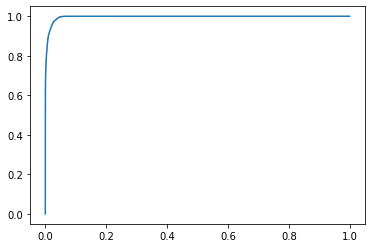

In [0]:
train_y_predict = stackModel.predict_proba(train_x_stack)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_y_predict, pos_label=1)
plt.plot(fpr,tpr)
for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break

print(thresholds[i])
thres = thresholds[i]

In [0]:
val_y_predict = stackModel.predict_proba(val_x_stack)[:,1]
test_y_predict = stackModel.predict_proba(test_x_stack)[:,1]

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

train score: 0.7695, val score: 0.7033, test score: 0.6916
train precision: 0.8141, val precision: 0.7874, test precision: 0.7753
train recall: 0.9972, val recall: 0.9634, test recall: 0.9738


In [0]:
for i, dns in enumerate(p1_data.dns[:int(n*train_ratio)]):
  if dns in alexa:
    train_y_predict[i] = 0

for i, dns in enumerate(p1_data.dns[int(n*train_ratio):int(n*(train_ratio+val_ratio))]):
  if dns in alexa:
    val_y_predict[i] = 0

for i, dns in enumerate(p1_data.dns[int(n*(train_ratio+val_ratio)):]):
  if dns in alexa:
    test_y_predict[i] = 0 

for i in range(len(fpr)):
  if fpr[i] > 0.05:
    print(i)
    break
print(thresholds[i])
thres = thresholds[i]

socre1_train = getSocre1(train_y_predict, train_y, thres)
score1_val = getSocre1(val_y_predict, val_y, thres)
score1_test = getSocre1(test_y_predict, test_y, thres)
print("train score: {0:.4f}, val score: {1:.4f}, test score: {2:.4f}".format(socre1_train, score1_val, score1_test))

tp_train, tn_train, fp_train, fn_train = Calrate(train_y_predict, train_y, thres)
tp_v, tn_v, fp_v, fn_v = Calrate(val_y_predict, val_y, thres)
tp_t, tn_t, fp_t, fn_t = Calrate(test_y_predict, test_y, thres)
print("train precision: {0:.4f}, val precision: {1:.4f}, test precision: {2:.4f}".format(tp_train/(tp_train+fp_train), tp_v/(tp_v+fp_v), tp_t/(tp_t+fp_t)))
print("train recall: {0:.4f}, val recall: {1:.4f}, test recall: {2:.4f}".format(tp_train/(tp_train+fn_train), tp_v/(tp_v+fn_v), tp_t/(tp_t+fn_t)))

1954
0.22411926
train score: 0.7799, val score: 0.7277, test score: 0.7252
train precision: 0.8419, val precision: 0.8193, test precision: 0.8099
train recall: 0.9602, val recall: 0.9337, test recall: 0.9477


**0.7252**